In [9]:
from math import sqrt, cos, sin, acos, pi, atan2
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
from numba import complex128,float64,int64,jit
import matplotlib.pyplot as plt
import numpy as np
import quadpy

#custom module
from fieldplot import GetFlow3D
from nanoscale_test import fieldplot2, rotateAroundX, rotateAroundY, rotateAroundZ, angle2D
from scattnlay import fieldnlay
from scattnlay import scattnlay

import nanoscale_test
import scattnlay

In [2]:
#import os
#print(os.environ['PIP_DEFAULT_TIMEOUT'])

In [10]:
import random
from deap import base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def createIndividual():
    x1 = random.randint(0, 60)
    x2 = random.randint(30, 60)
    if x1 > x2:
        x1, x2 = x2, x1
    #if x1 == x2:
    #    print("x1 == x2!")
    m1 = random.uniform(3, 6) + random.uniform(0, 0.4)*1j # 3..6 + 0..0.4j
    m2 = random.uniform(3, 6) + random.uniform(0, 0.4)*1j # 3..6 + 0..0.4j
    r = np.random.rand() * x1*factor + 1
    return [x1, x2, m1, m2, r]

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, createIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [11]:
%run kostin_kod.py

In [12]:
def evaluate(ind):
    x1, x2, m1, m2, r = ind

    if x1 == 0:
        x, m = np.array([x2]), np.array([m2])
    else:
        x, m = np.array([x1, x2]), np.array([m1, m2])
    
    quad_n = 31
    coords = get_points('quad', r=r, quad_n=quad_n)
    Iprj = integrand(coords, x, m)
    Ptot = quadpy.sphere.integrate(lambda coords: integrand(coords, x, m),
                            [0.0, 0.0, 0.0], r,
                            quadpy.sphere.Lebedev(str(quad_n))) / (4. * np.pi * r**2)
    return (3./4.*np.max(Iprj)/Ptot,)

def update_fitnesses(population):
        fitnesses = map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit
            
toolbox.register("evaluate", evaluate)

In [13]:
def one_plus_one(max_plato_time=100, all_mut_pb=1.0, log=False):
    def roll(ind):
        new_ind = createIndividual()
        
        if random.random() < all_mut_pb:
            k = len(ind)
        else:
            k = 1
        
        for i in random.sample(range(len(ind)), k):
            ind[i] = new_ind[i]
            
        if ind[0] > ind[1]:
            ind[:2] = new_ind[:2]
            
        return ind
    
    toolbox.register("mutate", roll)
    toolbox.register("select", tools.selBest, k=1)
    
    best = toolbox.individual()
    update_fitnesses([best])
    
    time_on_plato = 0
    gen = 0
    while True:
        applicant = toolbox.clone(best)
        applicant = toolbox.mutate(applicant)
        
        update_fitnesses([applicant])

        new_best = toolbox.select([best, applicant])[0]
        
        if log:
            print("Gen {}: best: {}, applicant: {}, new_best: {}".format(gen, best[0], applicant[0], new_best[0]))
        
        if new_best == best:
            time_on_plato += 1
            if time_on_plato == max_plato_time:
                break
        best = new_best
        gen += 1
        
    return best, best.fitness.values

In [17]:
from tqdm import tqdm_notebook as tqdm

MEASUREMENTS = 5

for i in tqdm(range(MEASUREMENTS)):
    print(one_plus_one(max_plato_time=1000, all_mut_pb=1.0))
    
for i in tqdm(range(MEASUREMENTS)):
    print(one_plus_one(max_plato_time=1000, all_mut_pb=1./5))

([1, 57, (4.666467091995608+0.32667333725454617j), (5.1535740134283206+0.337553690607576j), 1.088752396911604], (5.1836453973881085,))
([1, 58, (5.007666624130672+0.3813253627022024j), (3.579724795302518+0.06929993462846205j), 1.0777596635377211], (12.213425453034214,))
([40, 59, (3.36020419487598+0.07089228075555787j), (5.777466175441239+0.018301945683823595j), 27.407362407174745], (6.36386848527467,))
([23, 57, (4.191447823668925+0.2627587084937335j), (5.536087086192493+0.1384212746520507j), 27.944864938813406], (4.470637493037962,))
([1, 57, (5.539052417717674+0.22434780246514974j), (4.6824836796303595+0.048684810767162204j), 1.0404439640034375], (8.646626598997903,))



([21, 55, (4.940493380477779+0.07500932287524123j), (5.803085285956735+0.09867889042207706j), 31.061564595309967], (6.883158586548137,))
([1, 59, (3.5117810060221424+0.10534000741746984j), (3.557129167699604+0.09431665029110765j), 1.0], (47.9130234231266,))
([25, 54, (3.770443017741211+0.12039885391576576j), (5.956848536599981+0.31612135998131186j), 59.85687637840606], (5.0464110502941555,))
([53, 56, (5.862285473090028+0.009174739176045854j), (4.179064074319455+0.021667859332597718j), 49.2193115344831], (6.203375269591835,))
([14, 54, (4.252666744251233+0.08954444443894692j), (5.992347848311583+0.08175134521344139j), 30.086888475193863], (7.315298736978774,))



In [ ]:
# TODO
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

In [55]:
ind1 = toolbox.individual()

In [40]:
# 1+1
MAX_PLATO_STEPS = 1000

def roll():
    return np.random.rand() * x[-1]*factor

best = roll()
best_val = evaluate(best)
time_on_plato = 0

while True:
    applicant = roll()
    applicant_val = evaluate(applicant)
    if applicant_val > best_val:
        best, best_val = applicant, applicant_val
    else:
        time_on_plato += 1
        if time_on_plato == MAX_PLATO_STEPS:
            break

best

72.39503039550581

In [4]:
#visualization_test_of_projection_vectors(0)
#visualization_test_of_dipole_radiation()

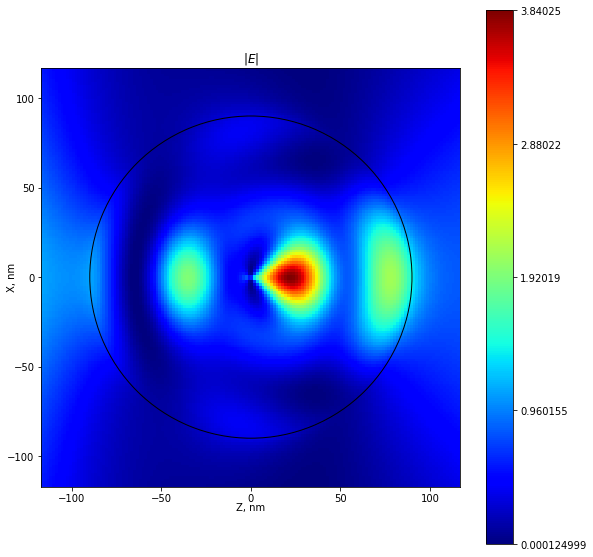

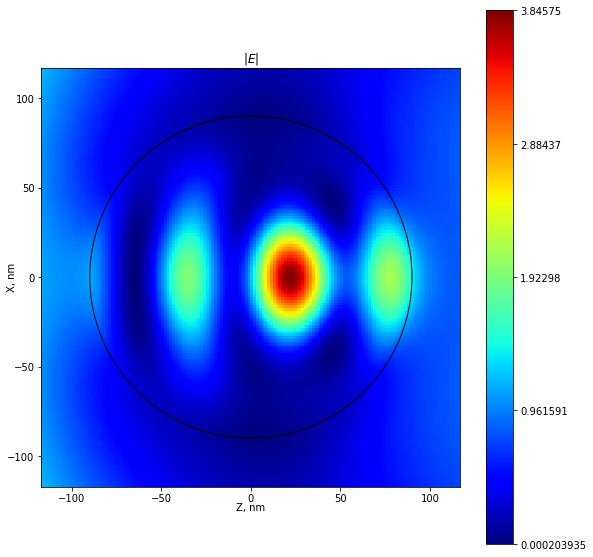

In [8]:
coords = get_points('meshXZ')
# Eamp = get_field(coords)
# Eabs = np.sqrt(Eamp[:, 0]**2 + Eamp[:, 1]**2 + Eamp[:, 2]**2)
Iprj = integrand(coords)
fieldplot2(Iprj, coords[:,0], coords[:,2], x, m, npts, factor)
#fieldplot2(Eabs, coords[:,0], coords[:,2], x, m, npts, factor)
#fieldplot2(Eamp[:,2], coords[:,0], coords[:,2], x, m, npts, factor)
plt.show()

coords = get_points('meshYZ')
Iprj = integrand(coords)
fieldplot2(Iprj, coords[:,1], coords[:,2], x, m, npts, factor)
plt.show()

CPU times: user 1.74 s, sys: 8.63 ms, total: 1.74 s
Wall time: 1.81 s


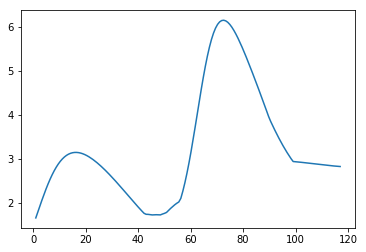

In [4]:
%%time
quad_n = 31
D = []
R = np.linspace(1, x[-1]*factor, num=150)
for r in R:
    #print("r =",r)
    coords = get_points('quad', r=r, quad_n=quad_n)
    Iprj = integrand(coords)
    Ptot = quadpy.sphere.integrate(integrand,
                            [0.0, 0.0, 0.0], r,
                            quadpy.sphere.Lebedev(str(quad_n))) / (4. * np.pi * r**2)
    #D.append(4.*np.pi*np.max(Iprj)/Ptot)
    D.append(3./4.*np.max(Iprj)/Ptot)
    #D.append(np.max(Iprj)/Ptot)
    # # print(Iprj)
    # vIprj = np.zeros(coords.shape)
    # for i in range(len(coords)):
    #     vIprj[i]=coords[i]*Iprj[i]
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(vIprj[:,0], vIprj[:,1], vIprj[:,2])
    # ax.set_xlim(-np.max(vIprj),np.max(vIprj))
    # ax.set_ylim(-np.max(vIprj),np.max(vIprj))
    # ax.set_zlim(-np.max(vIprj),np.max(vIprj))
    # plt.show()
D = np.array(D)
plt.plot(R,D)
#print(D)